In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from tueplots import bundles

plt.rcParams.update({"figure.dpi": 300})
plt.rcParams.update(bundles.neurips2022())
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.labelsize']=12

### Create the Mixture

In [ ]:
# Define the symbols, i.e., the modes of the discrete distribution
bpsk_symbols = [-1, 1]
pam4_symbols = [-6 / np.sqrt(20), -2 / np.sqrt(20), 2 / np.sqrt(20), 6 / np.sqrt(20)]

coeff = 10 ** (0.5 * 24 / 10)  # Choice of kappa corresponding to -24 dB

all_symbols = [a + coeff * b for a in bpsk_symbols for b in pam4_symbols]

In [ ]:
np.random.seed(1230)

s = np.random.choice(bpsk_symbols)  # The SOI is drawn as BPSK
b = np.random.choice(pam4_symbols)  # The intereference is drawn as 4-PAM
y = s + coeff * b  # Create the mixture

### Plot the GMMs for SOI and Interference

In [93]:
sigma1 = 0.008
sigma2 = 0.008
var_s = sigma1 ** 2
var_b = sigma2 ** 2

eps = 1e-24

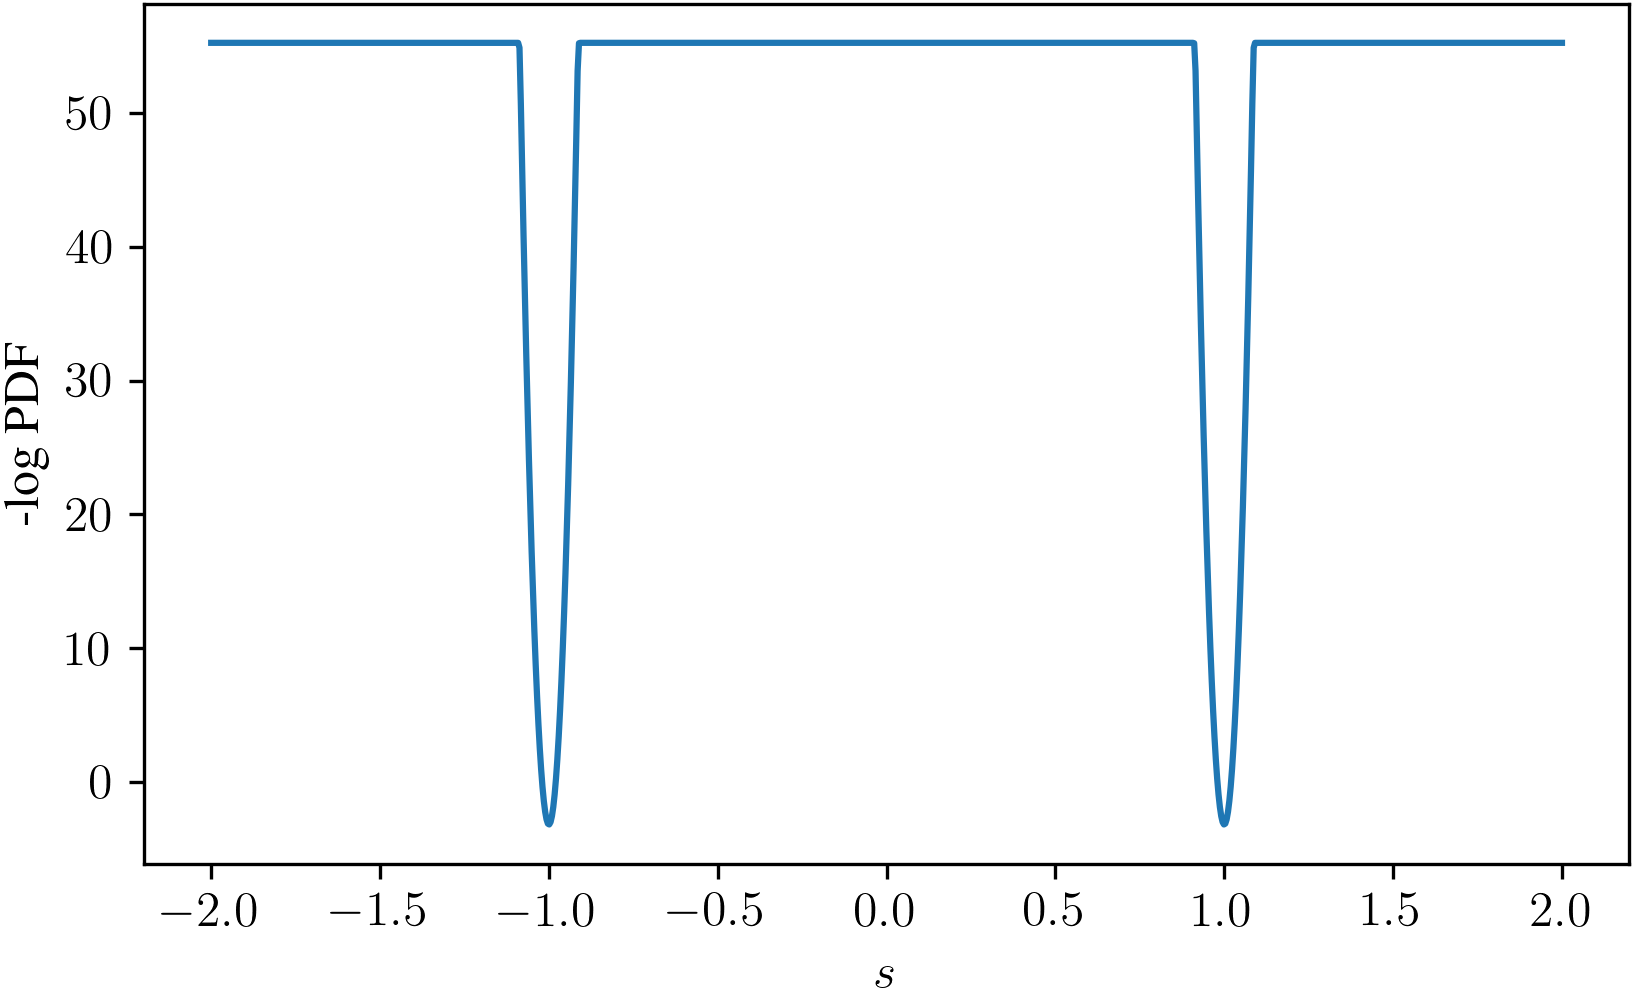

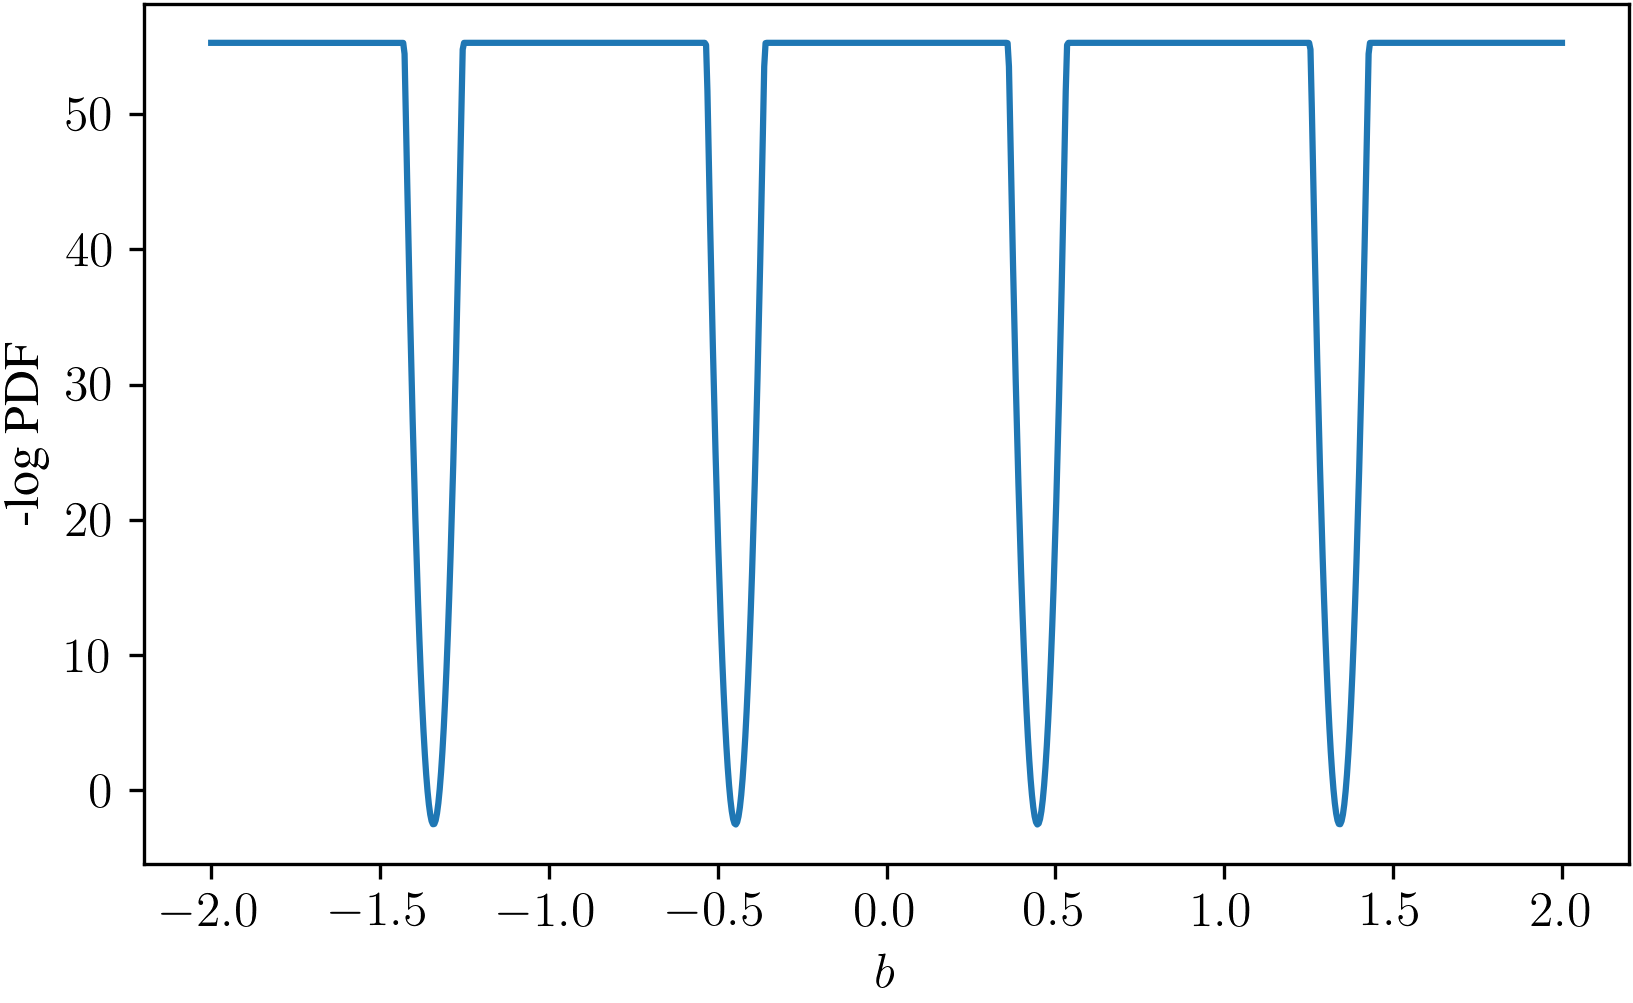

In [94]:
def plot_gaussian_mixture(mus, sigma, n_points=1000, show=True, xlabel=None):
    x = np.linspace(-2, 2, n_points)
    pdf = 0
    for mu in mus:
        mu_adj = np.sqrt(1-sigma**2)*mu
        pdf += stats.norm.pdf(x, mu_adj, sigma)
    pdf /= len(mus)
    if show:
        plt.plot(x, -np.log(pdf+eps))
        plt.ylabel('-log PDF')
        plt.xlabel(xlabel)
        plt.show()
    return x, pdf

x1, pdf1 = plot_gaussian_mixture(bpsk_symbols, sigma1, xlabel='$s$')
x2, pdf2 = plot_gaussian_mixture(pam4_symbols, sigma2, xlabel='$b$')

### Visualize the Joint Distribution using in MAP Estimation

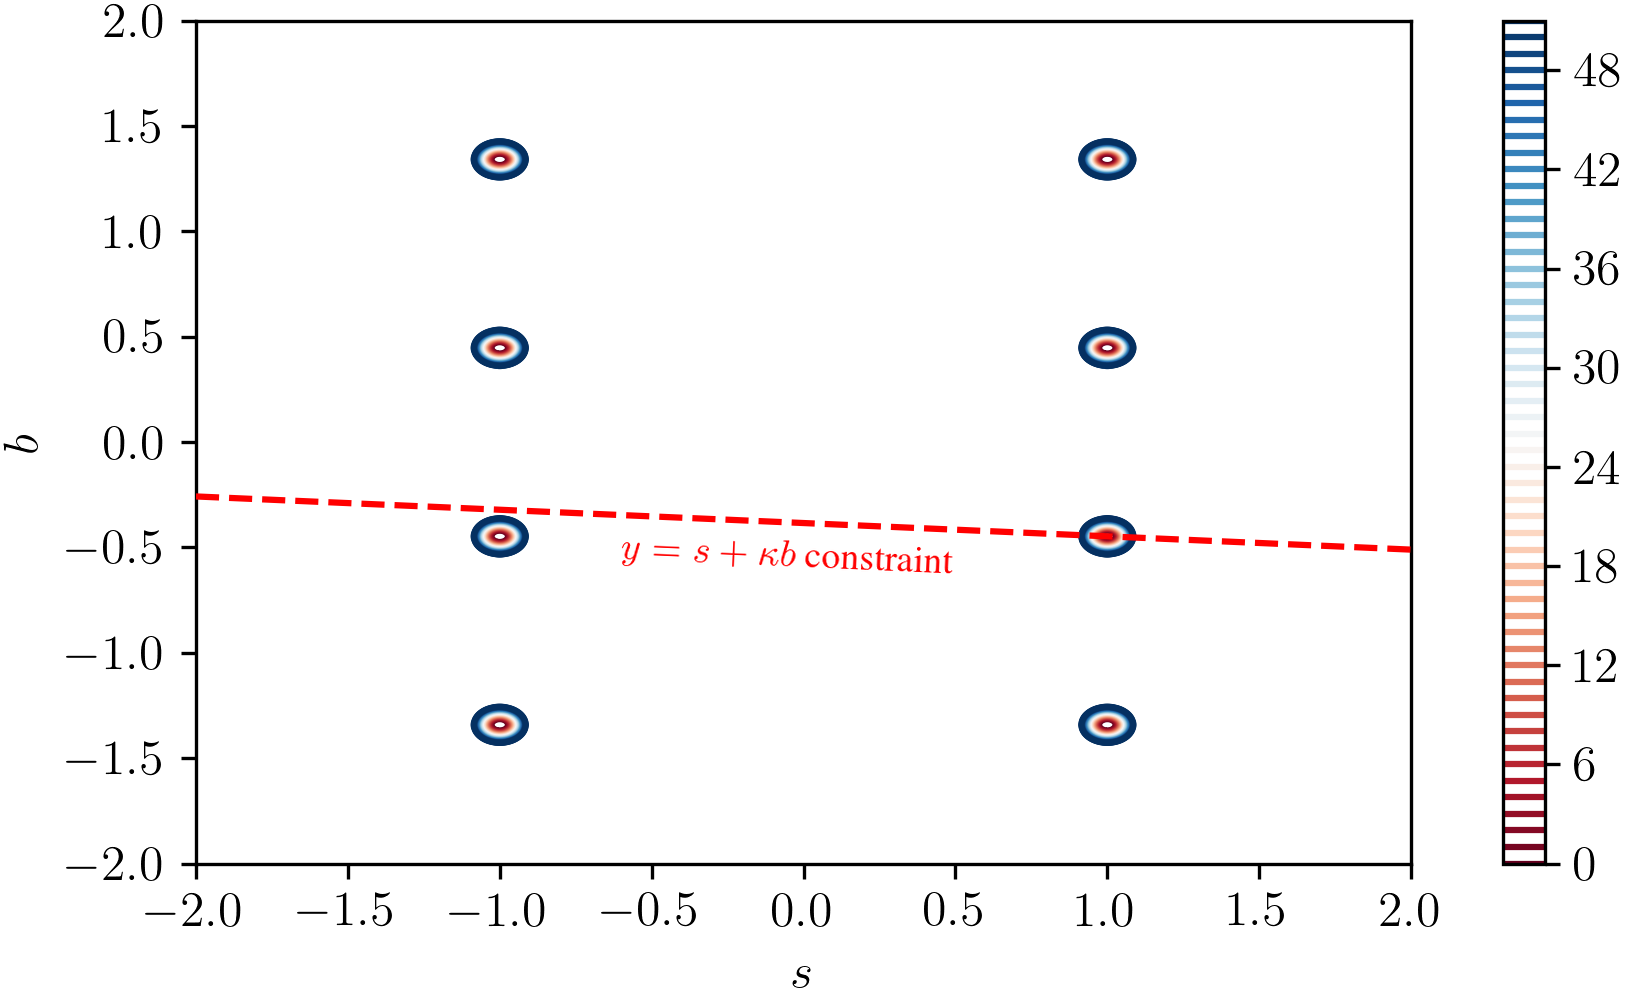

In [95]:
plt.figure()
pdf = -np.log(pdf1.reshape(1,-1)+eps) + -np.log(pdf2.reshape(-1,1)+eps)
x1_ax, x2_ax = np.meshgrid(x1, x2)
plt.plot(x1, 1/coeff*(y - x1), 'r--', zorder=99)
plt.contour(x1_ax, x2_ax, pdf, np.arange(0,52), cmap='RdBu')
plt.xlabel('$s$')
plt.ylabel('$b$')
plt.text(-0.6, -0.62, '$y = s + \kappa b$ constraint', color='red', rotation=-2.5)
plt.colorbar()
plt.show()

In [15]:
x1, pdf1 = plot_gaussian_mixture(bpsk_symbols, sigma1, 1000, False)
x2, pdf2 = plot_gaussian_mixture(pam4_symbols, sigma2, 1000, False)

pdf = -np.log(pdf1.reshape(1,-1)+eps) + -np.log(pdf2.reshape(-1,1)+eps)
x1_ax, x2_ax = np.meshgrid(x1, x2)

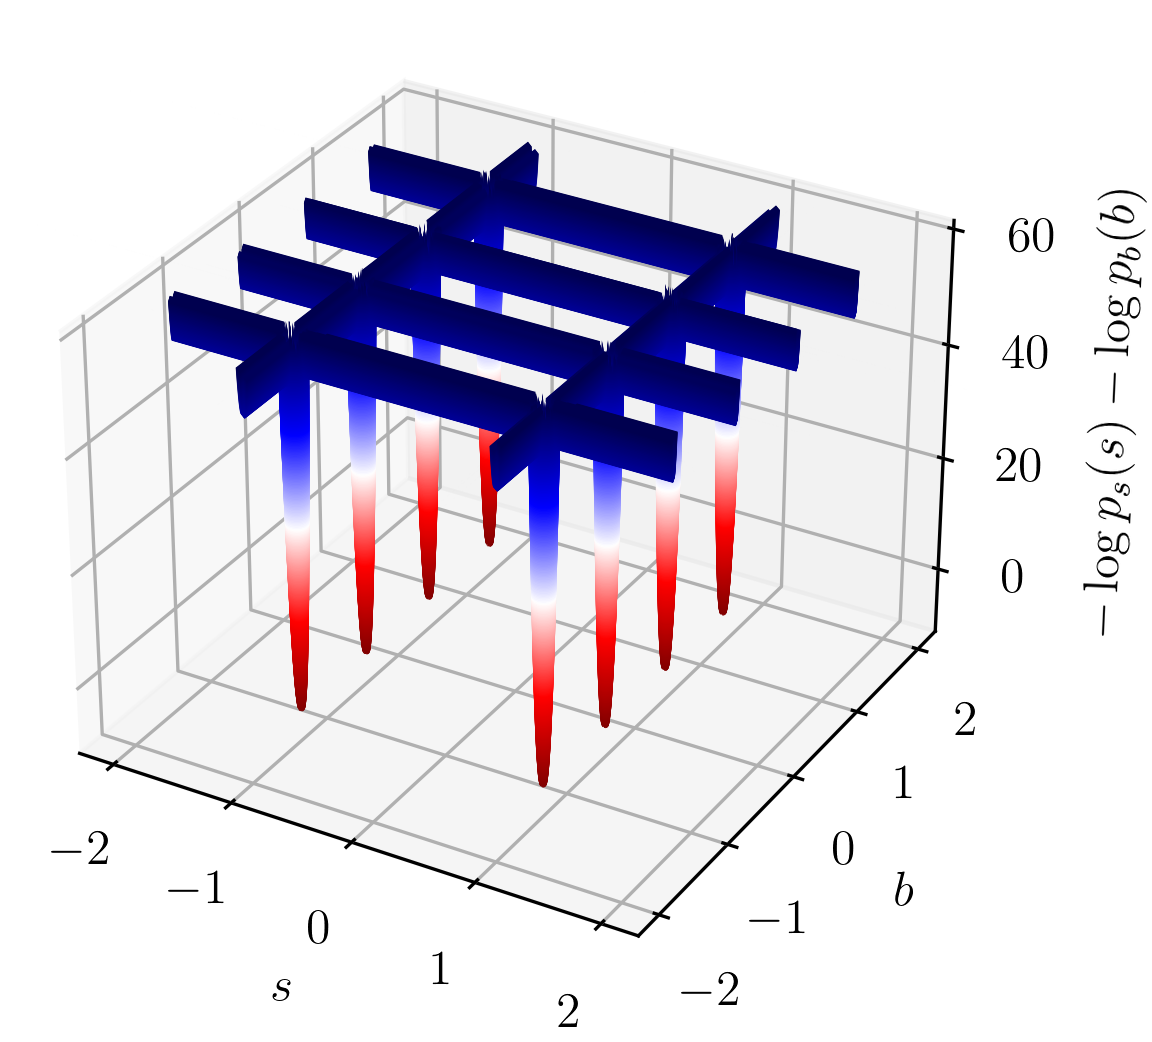

In [90]:
fig = plt.figure()
ax = plt.axes(projection = "3d")
pdf_to_plot = pdf.copy()
pdf_to_plot[pdf_to_plot>60] = np.nan

ax.contour(x1_ax, x2_ax, pdf_to_plot, 1000, cmap='seismic_r')
# ax.view_init(30, 30)
ax.set(xlabel='$s$', ylabel='$b$', zlabel='$-\\log p_s(s) - \\log p_b(b)$', zlim=(-10,60))
plt.show()

### Visualize the Joint Distribution after Applying $\alpha$-posterior

In [17]:
pdf_alpha = -np.log(pdf1.reshape(1,-1)+eps) + coeff**2 * -np.log(pdf2.reshape(-1,1)+eps)

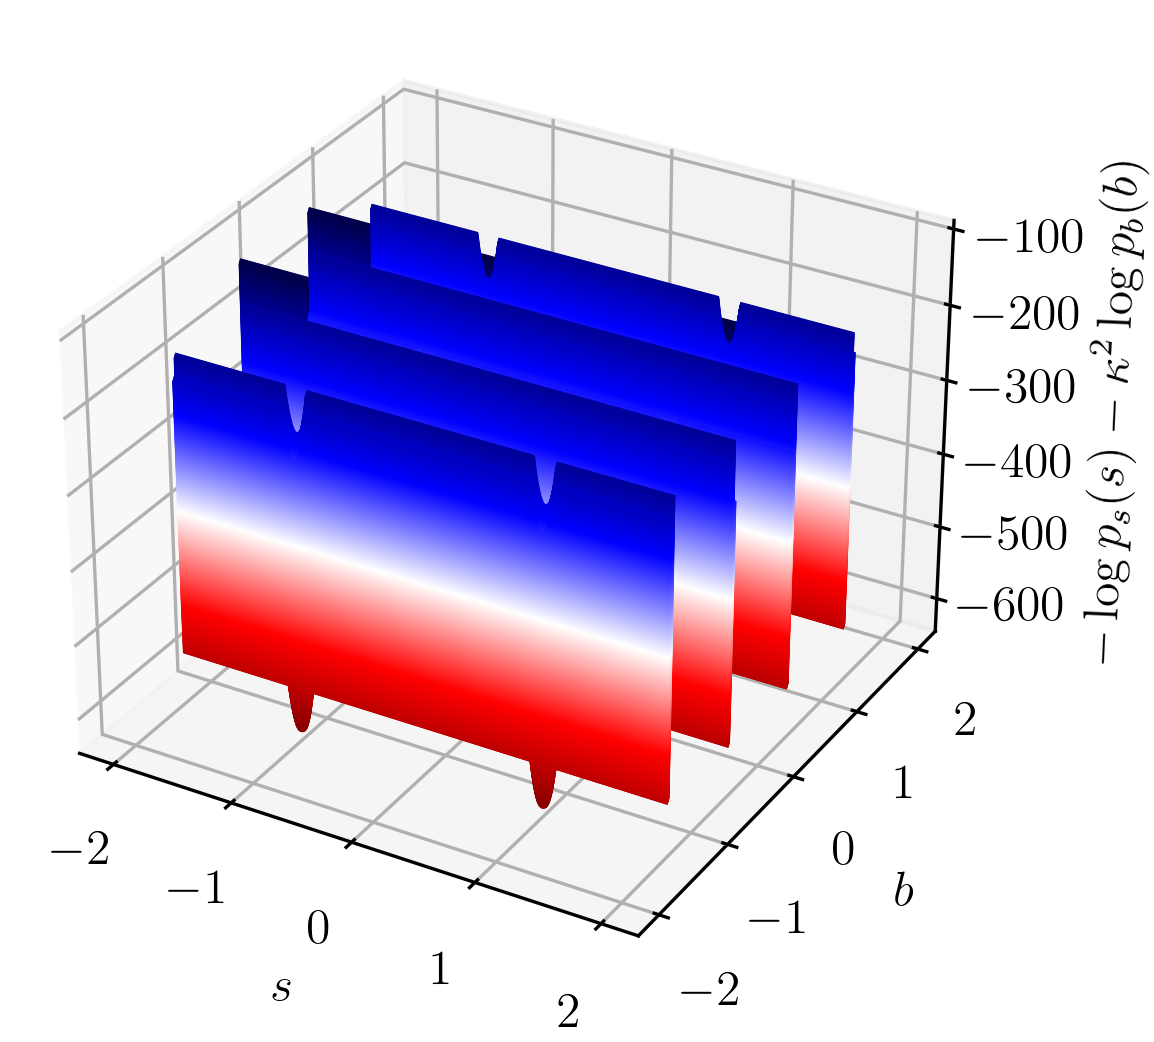

In [91]:
fig = plt.figure()
ax = plt.axes(projection = "3d")
pdf_alpha_to_plot = pdf_alpha.copy()
pdf_alpha_to_plot[pdf_alpha_to_plot>-100] = np.nan

ax.contour(x1_ax, x2_ax, pdf_alpha_to_plot, 1000, cmap='seismic_r')
# ax.view_init(30, 30)
ax.set(xlabel='$s$', ylabel='$b$', zlabel='$-\\log p_s(s) - \kappa^2 \\log p_b(b)$', zlim=(-635,-100))
plt.show()

In [36]:
def nlogpdfs(x, alpha):
    mus = bpsk_symbols
    pdf = 0
    for mu in mus:
        mu_adj = np.sqrt(alpha)*mu
        pdf += stats.norm.pdf(x, mu_adj, np.sqrt(1-alpha))
    pdf /= len(mus)
    return -np.log(pdf+eps)

def nlogpdfb(x, alpha):
    mub = pam4_symbols
    pdf = 0
    for mu in mub:
        mu_adj = np.sqrt(alpha)*mu
        pdf += stats.norm.pdf(x, mu_adj, np.sqrt(1-alpha))
    pdf /= len(mub)
    return -np.log(pdf+eps)

def simulate_at_alpha(alpha):
    theta_ax = np.linspace(-2,2,1000)
    explogpdf_map = np.zeros(theta_ax.shape)
    explogpdf_alphamap = np.zeros(theta_ax.shape)
    for i, theta in enumerate(theta_ax):
        z_noise1 = np.random.randn(10000)
        z_noise2 = np.random.randn(10000)
        s_t = np.sqrt(alpha) * theta + np.sqrt(1 - alpha) * z_noise1
        b_t = np.sqrt(alpha) * ((y - theta) / coeff) + np.sqrt(1 - alpha) * z_noise2
        
        explogpdf_map[i] = np.mean(nlogpdfs(s_t, alpha) + nlogpdfb(b_t, alpha))
        explogpdf_alphamap[i] = np.mean(nlogpdfs(s_t, alpha) + coeff ** 2 * nlogpdfb(b_t, alpha))
    return explogpdf_map, explogpdf_alphamap, theta_ax

In [79]:
oneminusalpha_values = [1e-6, 5e-6, 25e-6, 1e-4, 1e-3, 1e-2]
all_L_map, all_L_alphamap = [], [] 
for aa in oneminusalpha_values:
    alpha = 1 - aa
    L_map, L_alphamap, theta_ax = simulate_at_alpha(alpha)
    all_L_map.append(L_map)
    all_L_alphamap.append(L_alphamap)

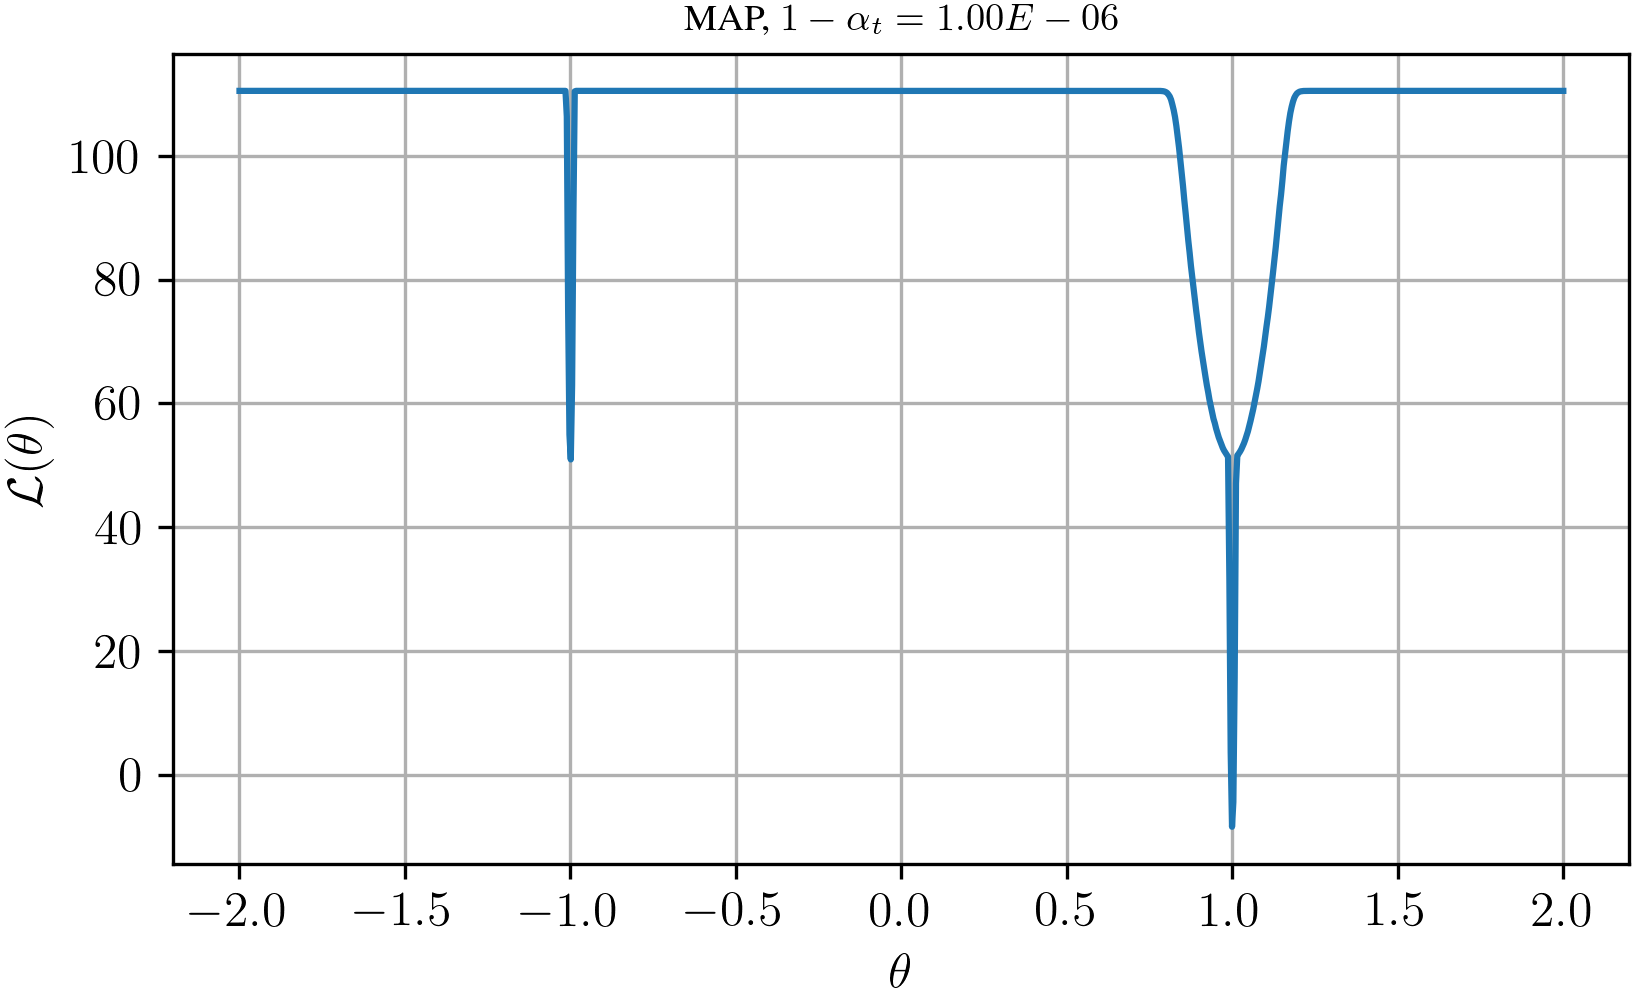

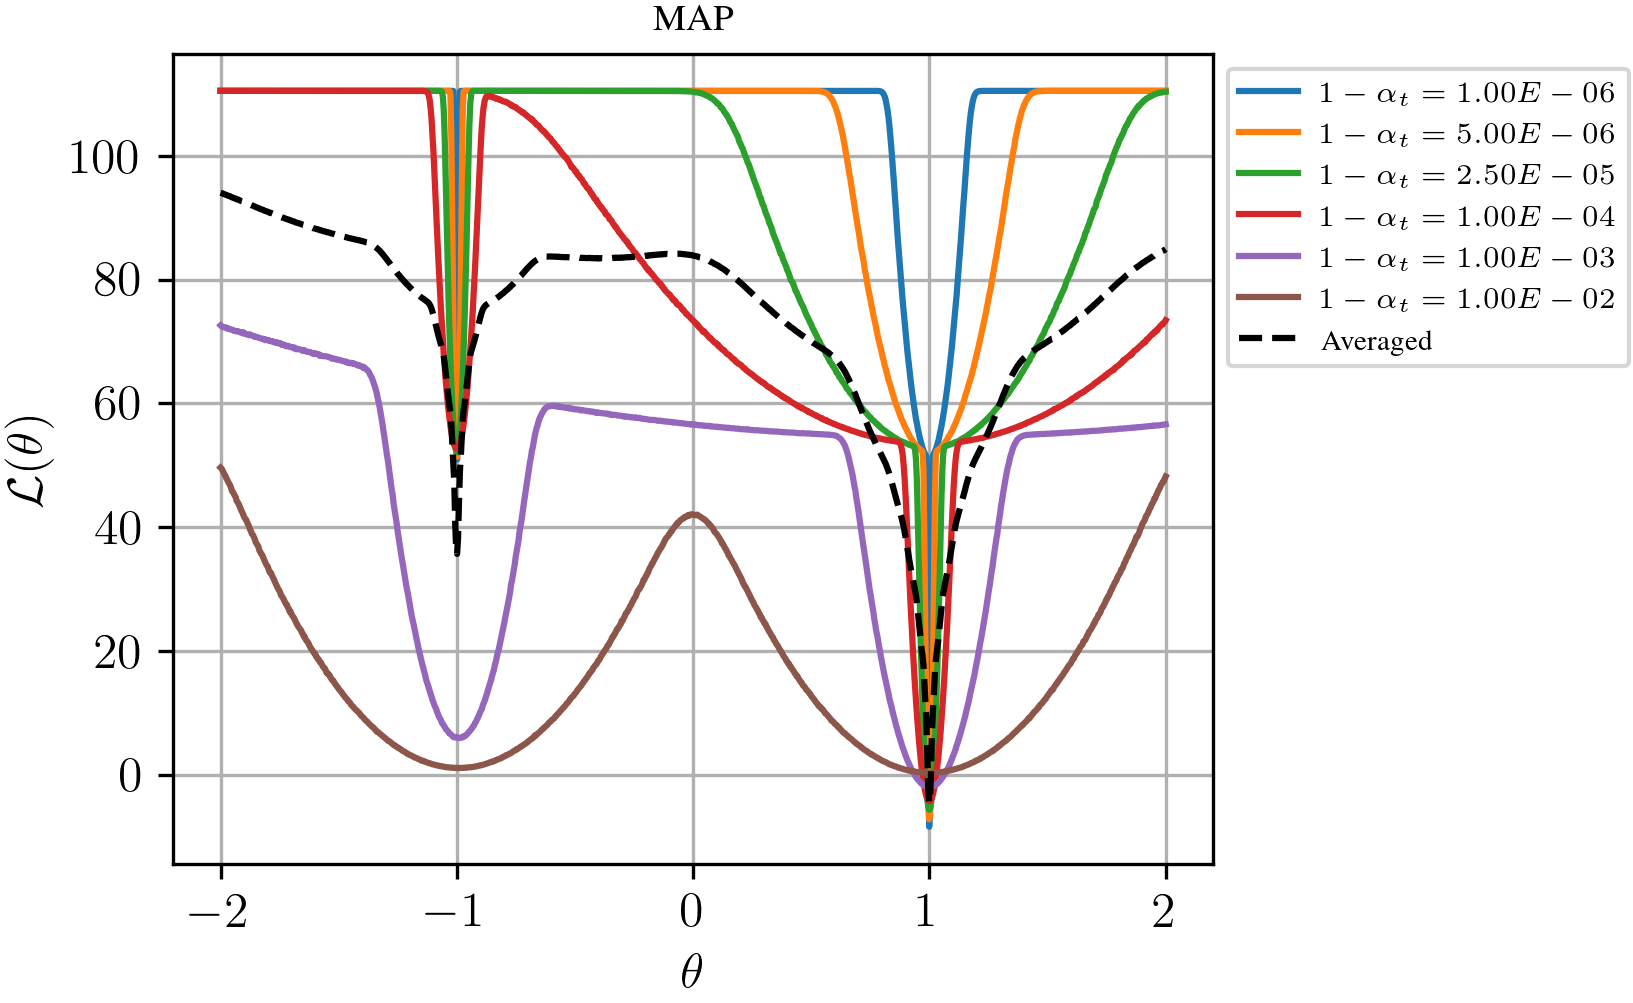

In [85]:
plt.figure()
plt.plot(theta_ax, all_L_map[0])
plt.ylabel('$\mathcal{L}(\\theta)$')
plt.xlabel('$\\theta$')
plt.title(f'MAP, $1-\\alpha_t={oneminusalpha_values[0]:.2E}$')
plt.grid()
plt.show()

plt.figure()
for i in range(len(all_L_map)):
    plt.plot(theta_ax, all_L_map[i])
plt.plot(theta_ax, np.mean(np.array(all_L_map), axis=0), 'k--')
plt.ylabel('$\mathcal{L}(\\theta)$')
plt.xlabel('$\\theta$')
plt.legend([f'$1-\\alpha_t={aa:.2E}$' for aa in oneminusalpha_values]+['Averaged'], bbox_to_anchor=(1,1))
plt.title(f'MAP')
plt.grid()
plt.show()

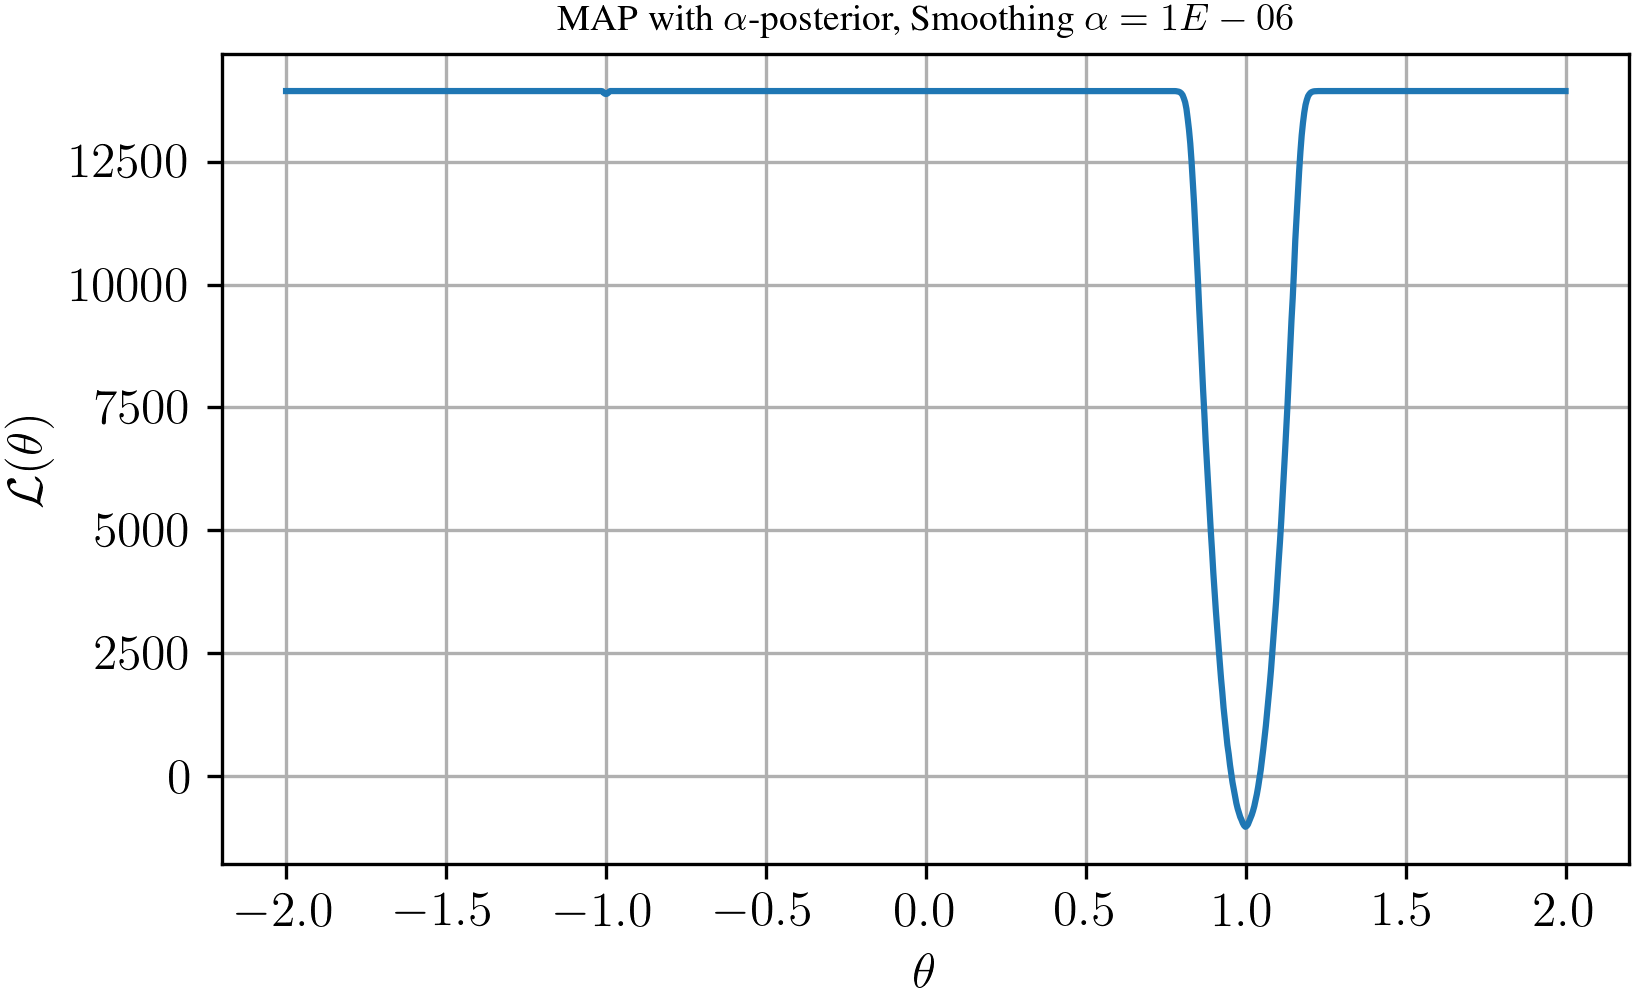

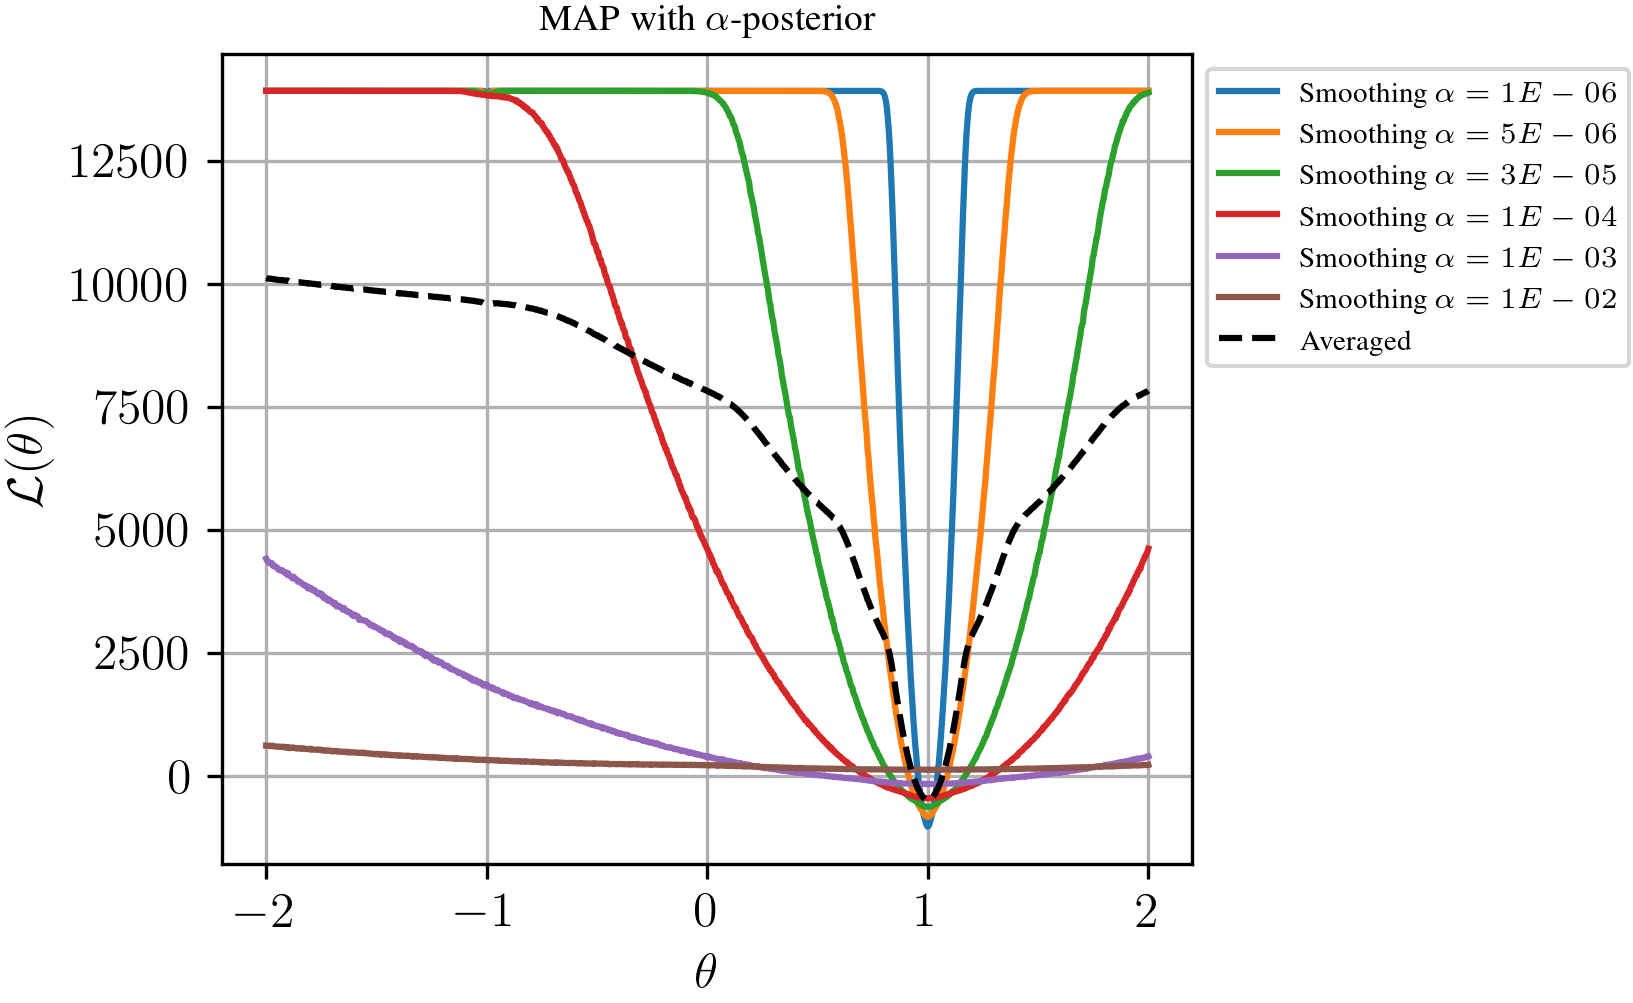

In [86]:
plt.figure()
plt.plot(theta_ax, all_L_alphamap[0])
plt.ylabel('$\mathcal{L}(\\theta)$')
plt.xlabel('$\\theta$')
plt.title(f'MAP with $\\alpha$-posterior, Smoothing $\\alpha={oneminusalpha_values[0]:.2E}$')
plt.grid()
plt.show()

plt.figure()
for i in range(len(all_L_alphamap)):
    plt.plot(theta_ax, all_L_alphamap[i])
plt.plot(theta_ax, np.mean(np.array(all_L_alphamap), axis=0), 'k--')
plt.ylabel('$\mathcal{L}(\\theta)$')
plt.xlabel('$\\theta$')
plt.legend([f'Smoothing $\\alpha={aa:.0E}$' for aa in oneminusalpha_values]+['Averaged'], bbox_to_anchor=(1,1))
plt.title(f'MAP with $\\alpha$-posterior')
plt.grid()
plt.show()